# Analysis

In [1]:
import pandas as pd
import plotnine as pn


In [2]:
# Load data

# Pareto frontier
curve_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/curve_points.csv"

# Counterpart points
counterpart_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/counterpart_points.csv"

# Explored hypothetical systems
sampled_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/sampled_points.csv"

# simulation points
alphas = [
    # 0, 
    # 2, 
    4, 
    # 6, 
    # 8, 
    10,
    ]

# Learned
# dynamic = "reinforcement_learning"
dynamic = "replicator_dynamic"
# num_trials = 10
num_trials = 100

alpha_fns = {
    f"{float(alpha)}":f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials={num_trials}/sim_param={alpha}/simulation_points.csv"
    for alpha in alphas
}


In [3]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_data = pd.read_csv(counterpart_fn)
sampled_data = pd.read_csv(sampled_fn)
simulation_dataframes = {
    k: pd.read_csv(alpha_fns[k]) for k in alpha_fns
}

In [4]:
# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df["alpha"] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,round,alpha
0,0.010012,16.523576,0,4.0
1,0.009620,16.186918,1,4.0
2,0.010572,15.954455,2,4.0
3,0.013897,15.712807,3,4.0
4,0.022340,15.305067,4,4.0
...,...,...,...,...
11956,0.000015,28.499475,44,10.0
11957,0.000010,28.499647,45,10.0
11958,0.000007,28.499762,46,10.0
11959,0.000005,28.499840,47,10.0


In [5]:
sim_data["alpha"] = sim_data["alpha"].astype(float)
# sim_data["alpha"] = sim_data["alpha"].astype(str)
counterpart_data["alpha"] = counterpart_data["alpha"].astype(float)
# counterpart_data["alpha"] = counterpart_data["alpha"].astype(str)

sim_data

,rate,distortion,round,alpha
0,0.010012,16.523576,0,4.0
1,0.009620,16.186918,1,4.0
2,0.010572,15.954455,2,4.0
3,0.013897,15.712807,3,4.0
4,0.022340,15.305067,4,4.0
...,...,...,...,...
11956,0.000015,28.499475,44,10.0
11957,0.000010,28.499647,45,10.0
11958,0.000007,28.499762,46,10.0
11959,0.000005,28.499840,47,10.0


In [6]:
# plot each language, with a unique color for each gamma

counterpart_data = counterpart_data.assign(
        alpha=pd.Categorical(
            counterpart_data["alpha"], 
            categories=[g for g in simulation_dataframes.keys()]
        )
    )

sim_data = sim_data.assign(
        alpha=pd.Categorical(
            sim_data["alpha"], 
            categories=[g for g in simulation_dataframes.keys()]
        )
    )  # preserve order in legend

# Language keys
sim_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]
sampled_data["language"] = "hypothetical"
counterpart_data["language"] = "optimal counterpart"
all_data = pd.concat([counterpart_data, sim_data])

# Trajectory keys
sim_data["time step"] = sim_data["round"]

counterpart_data


,rate,distortion,beta,alpha,language
0,3.321928,0.000000,1000.000000,NaN,optimal counterpart
1,0.963131,1.822883,0.250000,NaN,optimal counterpart
2,0.057531,7.616357,0.062500,4.0,optimal counterpart
3,0.004647,8.272144,0.027778,NaN,optimal counterpart
4,0.001560,8.380513,0.015625,NaN,optimal counterpart
5,0.000757,8.463557,0.010000,10.0,optimal counterpart


In [7]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        size=1,
        alpha=0.1,
    )        
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color="alpha", 
            shape="language",
            ),
        alpha=0.3,
        size=3,
        # height=0.1,
    )
    + pn.geom_line(size=1) # pareto data       
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_data,
        mapping=pn.aes(
            color="alpha",
            shape="language",
            ),
        size=4,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
)
print(plot)

TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + "/multiple_alpha.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics=replicator_dynamic/num_trials=100/multiple_alpha.png


## Plot trajectories

rate           float64
distortion     float64
round            int64
alpha         category
language        object
time step        int64
dtype: object

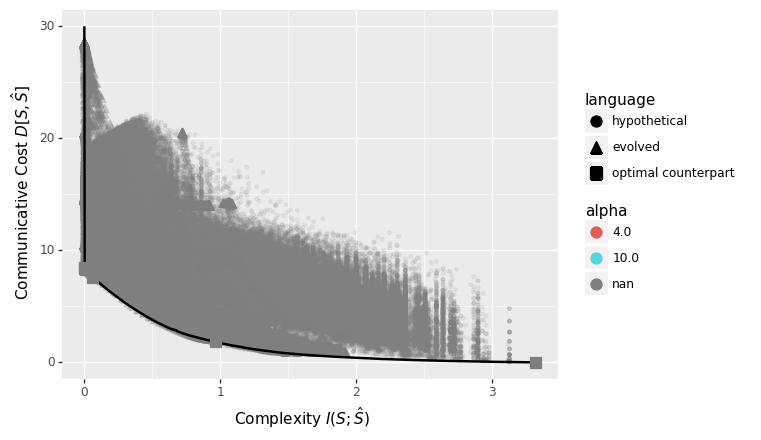

In [ ]:
# # use means and plot one line per discriminative need
# sim_data["alpha"] = sim_data["alpha"].astype(float) # need alpha back to numeric
# sim_data.groupby(['round']).mean()
# sim_data["alpha"] = sim_data["alpha"].astype(str) # need alpha back to str for category
# sim_data

display(sim_data.dtypes)
loss_plot = (
    pn.ggplot(data=sim_data, mapping=pn.aes(x="rate", y="distortion"))
    + pn.geom_line(pn.aes(color="alpha"))
)
print(plot)

In [ ]:
plot = (
    # Set data and the axes
    pn.ggplot(
            data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  # pareto data    
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        # shape="o",
        size=1,
        alpha=0.2,
    )        
    + pn.geom_line(  # simulation langs
        data=sim_data_means,
        mapping=pn.aes(color="alpha", shape="language"),
        # shape="o",
        alpha=0.01,
        size=3,
    )
    + pn.geom_line(size=1) # pareto last
    + pn.xlab("Rate I(S;A)")
    + pn.ylab("Distortion d(S, A)")
)
print(plot)

NameError: name 'sim_data_means' is not defined